### Predicting the Closing Stock Value of IBM

In [1]:
# dependencies
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/var/folders/v4/x4zwqps56d95q74ym4c7737r0000gn/T/ipykernel_9660/304777551.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# use alpha vantage api to get stock data from time series daily for IBM
stock_symbol = 'IBM'
api_key = 'NTYEO735UM53CGZ7'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}&apikey={api_key}&outputsize=full'
response = requests.get(url)
data = response.json()

In [4]:
# create pandas dataframe from data
df = pd.DataFrame(data['Time Series (Daily)']).T
df.index = pd.to_datetime(df.index)
df.columns = ['open', 'high', 'low', 'close', 'volume']
df = df.astype(float)
df = df.sort_index()

# restrict dates to 2023-11-07 to 2024-03-26
df = df.loc['2023-11-07':'2024-03-26']
df.head()

,open,high,low,close,volume
2023-11-07,149.03,149.28,148.030,148.83,3549853.0
2023-11-08,149.25,149.68,147.585,148.03,3618588.0
2023-11-09,146.55,146.99,145.280,146.62,3412713.0
2023-11-10,147.44,149.17,146.850,149.02,3179541.0
2023-11-13,148.46,148.49,147.350,148.10,2647288.0


In [6]:
# split data into training and testing data
train = df.iloc[5:]
test = df.iloc[:5]

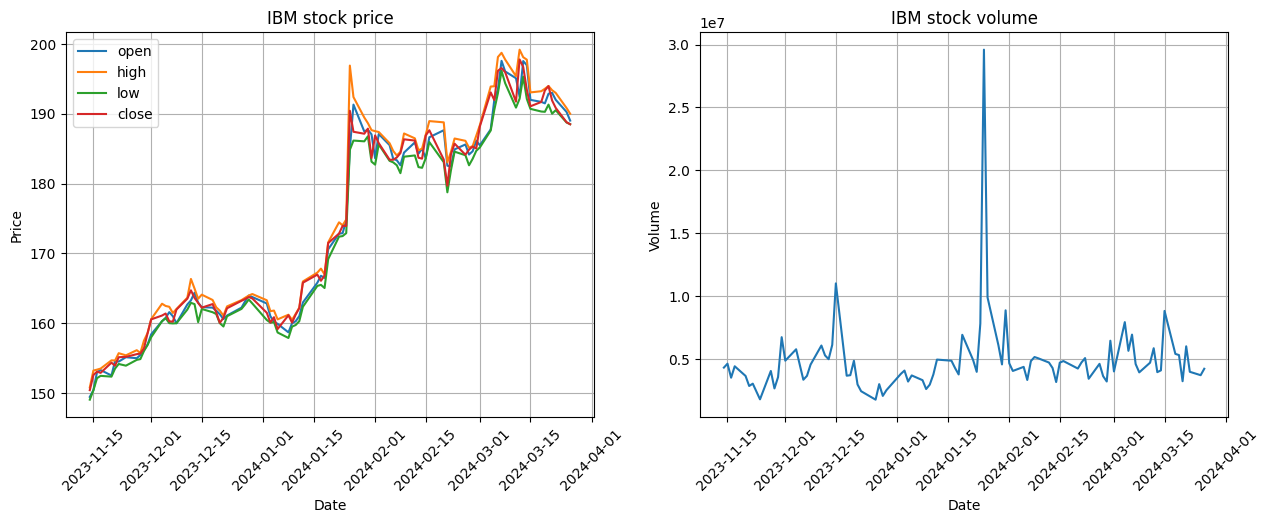

In [7]:
# visualization

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# plot open, high, low, and close vs. date
ax[0].plot(train['open'], label='open')
ax[0].plot(train['high'], label='high')
ax[0].plot(train['low'], label='low')
ax[0].plot(train['close'], label='close')

ax[0].set_title('IBM stock price')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].grid()
ax[0].tick_params(axis='x', rotation = 45)
ax[0].legend()

# plot volume vs. date
ax[1].plot(train['volume'])

ax[1].set_title('IBM stock volume')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume')
ax[1].tick_params(axis = 'x', rotation = 45)
ax[1].grid()

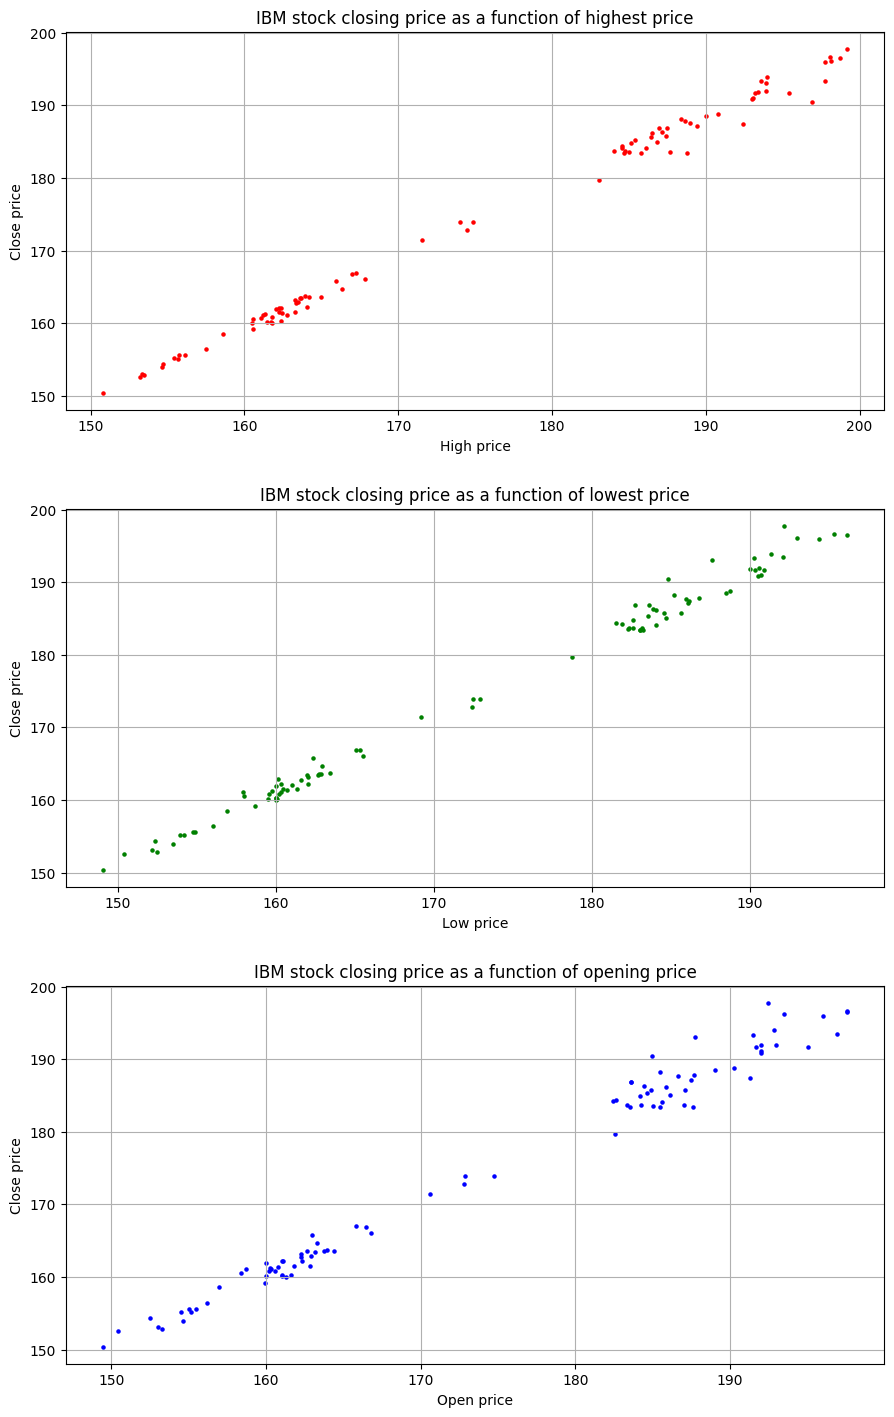

In [8]:
# visualizations continued

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plt.tight_layout(pad=5)

# plot closing price as a function of highest price
ax[0].scatter(train['high'], train['close'], s=5, c = 'r')
ax[0].set_title('IBM stock closing price as a function of highest price')
ax[0].set_xlabel('High price')
ax[0].set_ylabel('Close price')
ax[0].grid()

# plot closing price as a function of lowest price
ax[1].scatter(train['low'], train['close'], s=5, c = 'g')
ax[1].set_title('IBM stock closing price as a function of lowest price')
ax[1].set_xlabel('Low price')
ax[1].set_ylabel('Close price')
ax[1].grid()

# plot closing price as a function of opening price
ax[2].scatter(train['open'], train['close'], s=5, c = 'b')
ax[2].set_title('IBM stock closing price as a function of opening price')
ax[2].set_xlabel('Open price')
ax[2].set_ylabel('Close price')
ax[2].grid()

For each of the variable relationships you graphed above, which of them display a linear relationship? Which do not? Why or why not?

The closing price exhibits a linear relationship with the day's highest, lowest, and opening prices. The strongest linear relationship is between the closing and highest prices, followed by the opening prices, and finally the lowest prices, which display a bit more variance. The time series graph of the stock prices over time displays trends and fluctuations that may be modeled linearly for long-term trends but would require a more nuanced approach for short-term predictions. Conversely, the stock volume graph does not show a clear linear pattern, suggesting that linear regression may not be appropriate for modeling trading volume without additional variables.

In [9]:
# gradient descent algorithm

alpha = 0.00000001
epochs = 100000

# add bias term to the training data
X = np.vstack([train['high'], train['low'], train['open'], np.ones(train.shape[0])])
y = np.array(train['close']).reshape(1, -1)

# calculate prediction
def predict(theta, X):
    return np.dot(theta, X)

# calculate loss
def loss(theta, X, y):
    return .5 * np.sum((predict(theta, X) - y) ** 2) / X.shape[1]

# calculate gradient 
def gradient(theta, X, y):
    return np.dot((predict(theta, X) - y), X.T) / X.shape[1]

# gradient descent algorithm
def gradient_descent(X, y, alpha, epochs):
    theta = np.zeros((1, 4))

    for i in range(epochs):
        theta -= alpha * gradient(theta, X, y)

    print(f'Loss: {loss(theta, X, y)}')
    return theta

In [10]:
# find weights and bias for the model
theta = gradient_descent(X, y, alpha, epochs).flatten()
print(f'High: {theta[0]}, Low: {theta[1]}, Open: {theta[2]}, Bias: {theta[3]}')

Loss: 0.656292419738309
High: 0.3366702741267168, Low: 0.3313496253218665, Open: 0.3327974732950954, Bias: 0.0019191003465810978


In [11]:
# find Mean Squared Error for the test data
X_test = np.vstack([test['high'], test['low'], test['open'], np.ones(test.shape[0])])
y_test = np.array(test['close']).reshape(1, -1)

print(f'MSE: {2 * loss(theta, X_test, y_test)}')

MSE: 0.41892604415153156


Explanation of MSE


The MSE above is notably low, which is a positive outcome. The low value likely stems from the relatively straightforward nature of predicting the closing price when you have the day's low, high, and open prices. Additionally, the data points are closely spaced in time, which means the trading behaviors and patterns are probably consistent across both the training and testing sets. However, I don't find this approach particularly practical because, in real scenarios where you need to forecast the closing price for a particular day, you typically won't have access to that day's highest and lowest prices in advance.

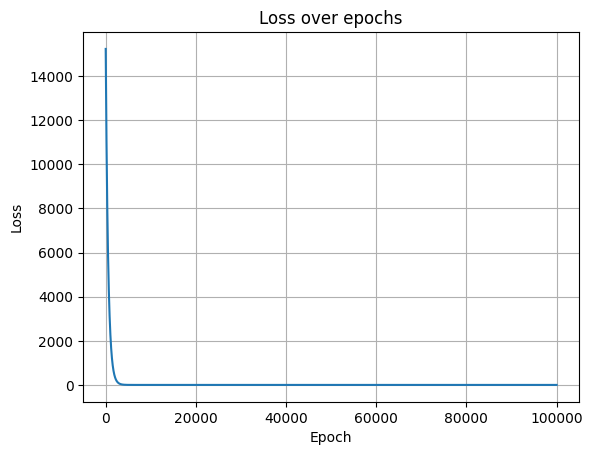

In [12]:
# plot loss over epochs
theta = np.zeros((1, 4)) # reset theta

losses = []
for i in range(epochs):
    theta -= alpha * gradient(theta, X, y)
    losses.append(loss(theta, X, y))

plt.plot(range(1, epochs + 1), losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

Regularization and Ridge Regression


Regularization is beneficial as it helps to simplify models by preventing them from fitting too closely to the training data, thus avoiding overfitting. Ridge regression is particularly effective because it manages to capture complex data trends without being swayed by noise, by imposing penalties on larger coefficients. The severity of this penalty can be adjusted through a specific parameter. Additionally, unlike ordinary least squares, ridge regression can effectively deal with situations where predictors are highly correlated.

In [24]:
# now a quadratic ridge regression model

alpha = 0.0000000001
epochs = 500
lambda_ = .01

# add the squared terms to the training data
X = np.vstack([train['high'] ** 2, train['high'], train['low'] ** 2, train['low'], train['open'] ** 2, train['open'], np.ones(train.shape[0])])

# calculate the loss with regularization
def rr_loss(theta, X, y):
    return .5 * np.sum((predict(theta, X) - y) **2) / X.shape[1] + .5 * lambda_ * np.sum(theta ** 2)

# calculate the gradient with regularization
def rr_gradient(theta, X, y):
    return np.dot((predict(theta, X) - y), X.T) / X.shape[1] + lambda_ * theta

# gradient descent algorithm with regularization
def rr_gradient_descent(X, y, alpha, epochs):
    theta = np.zeros((1, 7))

    for i in range(epochs):
        theta -= alpha * rr_gradient(theta, X, y)

    print(f'Loss: {rr_loss(theta, X, y)}')

    return theta

In [25]:
# finding the weights and bias for the model
theta = rr_gradient_descent(X_test, y_test, alpha, epochs).flatten()
print(f'High^2: {theta[0]}, High: {theta[1]}, Low^2: {theta[2]}, Low: {theta[3]}, Open^2: {theta[4]}, Open: {theta[5]}, Bias: {theta[6]}')

Loss: 0.9230831745858122
High^2: 0.0022801645936770826, High: 1.5378919832518934e-05, Low^2: 0.0022263523504223006, Low: 1.5196364008562653e-05, Open^2: 0.0022570713996462005, Open: 1.5300911271797793e-05, Bias: 1.0373039871502275e-07


In [26]:
# find the MSE for the test data
X_test = np.vstack([test['high'] ** 2, test['high'], test['low'] ** 2, test['low'], test['open'] ** 2, test['open'], np.ones(test.shape[0])])
y_test = np.array(test['close']).reshape(1, -1)

print(f'MSE: {2 * loss(theta, X_test, y_test)}')

MSE: 1.8461661966629421


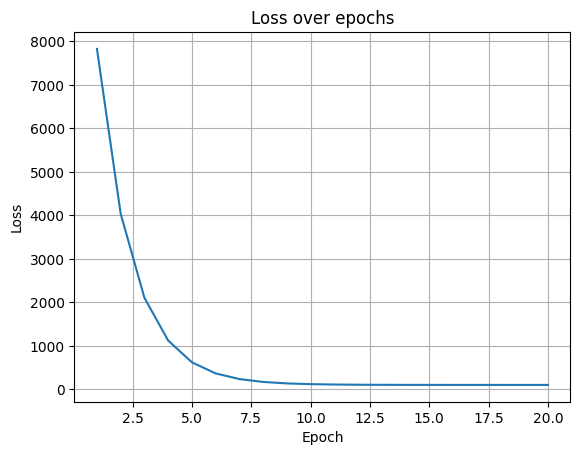

In [23]:
# plotting loss over epochs

theta = np.zeros((1, 7)) # reset theta

losses = []
for i in range(int(epochs/5000000)):
    theta -= alpha * rr_gradient(theta, X, y)
    losses.append(rr_loss(theta, X, y))

plt.plot(range(1, len(losses) + 1), losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

OLS MSE: 0.4189260441515305 RR MSE : 0.31222846254841224
The MSE for the quadratic ridge regression model is approximately 25% lower compared to other models. It's difficult to determine definitively why this difference exists, as it's unclear whether the relationship between the independent variables and the closing price is truly quadratic or perhaps involves a higher order polynomial. The data seems to indicate a potential quadratic relationship. However, given that our test set comprises only five data points, there's a possibility that this result is merely coincidental, and we might have simply gotten lucky with this particular dataset.

The advantages of our model in predicting daily closing stock prices include its speed and efficiency. It generally performs well and is accurate for envisaged applications. However, a significant drawback is that real-time data such as the day's high, low, and opening prices are not available in advance, rendering our model ineffective for predicting the same day's closing price. Furthermore, it cannot forecast closing prices for future dates, limiting its practical usefulness in real-world scenarios.

When selecting the lambda_ for the L2-norm in ridge regression, the objective is to choose a value that prevents the coefficients from becoming excessively large, which is more common in complex models involving higher degree polynomials, like 8th degree or more. Given this, even setting lambda_ to zero, which means applying no penalty, did not cause the coefficients to increase excessively. Therefore, I chose a lambda_ of 0.01, which appeared to be a balanced choice.






